# Global Forecasting Models: Dependent multi-series forecasting (Multivariate forecasting)

[Univariate time series forecasting](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html) models a single time series as a linear or nonlinear combination of its lags, using past values of the series to predict its future. Global forecasting, involves building a single predictive model that considers all time series simultaneously. It attempts to capture the core patterns that govern the series, thereby mitigating the potential noise that each series might introduce. This approach is computationally efficient, easy to maintain, and can yield more robust generalizations across time series.

In **dependent multi-series forecasting (multivariate time series)**, all series are modeled together in a single model, considering that each time series depends not only on its past values but also on the past values of the other series. The forecaster is expected not only to learn the information of each series separately but also to relate them. An example is the measurements made by all the sensors (flow, temperature, pressure...) installed on an industrial machine such as a compressor.

<p style="text-align: center">
<img src="../img/forecaster_multivariate_train_matrix_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Internal Forecaster time series transformation to train a forecaster with multiple dependent time series.</i></font>
</p>

Since as many training matrices are created as there are series in the dataset, it must be decided on which level the forecasting will be performed. To predict the next *n* steps a model is trained for each step to be predicted, the selected level in the figure is `Series 1`. This strategy is of the type [direct multi-step forecasting](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html#direct-multi-step-forecasting).

<p style="text-align: center">
<img src="../img/forecaster_multivariate_prediction_diagram.png" style="width: 700px">
<br>
<font size="2.5"> <i>Diagram of direct forecasting with multiple dependent time series.</i></font>
</p>


Using the `ForecasterAutoregMultiVariate` class, it is possible to easily build machine learning models for dependent multi-series forecasting.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Skforecast offers additional approaches to create Global Forecasting Models:

<ul>
    <li>
    <a href="https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting">Global Forecasting Models: Independent multi-series forecasting</a>
    </li>
    <li>
    <a href="https://skforecast.org/latest/user_guides/multi-series-with-different-length-and-different_exog">Global Forecasting Models: Time series with different lengths and different exogenous variables</a>
    </li>
    <li>
    <a href="https://skforecast.org/latest/user_guides/window-features-and-custom-features#forecasterautoregmultiseriescustom">Global Forecasting Models: Independent multi-series forecasting using window and custom features</a>
    </li>
</ul>

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

## Data

In [2]:
# Data download
# ==============================================================================
url = (
       'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/guangyuan_air_pollution.csv'
)
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data = data[['CO', 'SO2', 'PM2.5']]
data.head()

CO     SO2   PM2.5
date                               
2013-03-01   9600.0   204.0   181.0
2013-03-02  20198.0   674.0   633.0
2013-03-03  47195.0  1661.0  1956.0
2013-03-04  15000.0   485.0   438.0
2013-03-05  59594.0  2001.0  3388.0

In [3]:
# Split data into train-val-test
# ==============================================================================
end_train = '2016-05-31 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}"
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}"
    f"(n={len(data_test)})"
)

Train dates : 2013-03-01 00:00:00 --- 2016-05-31 00:00:00(n=1188)
Test dates  : 2016-06-01 00:00:00 --- 2017-02-28 00:00:00(n=273)


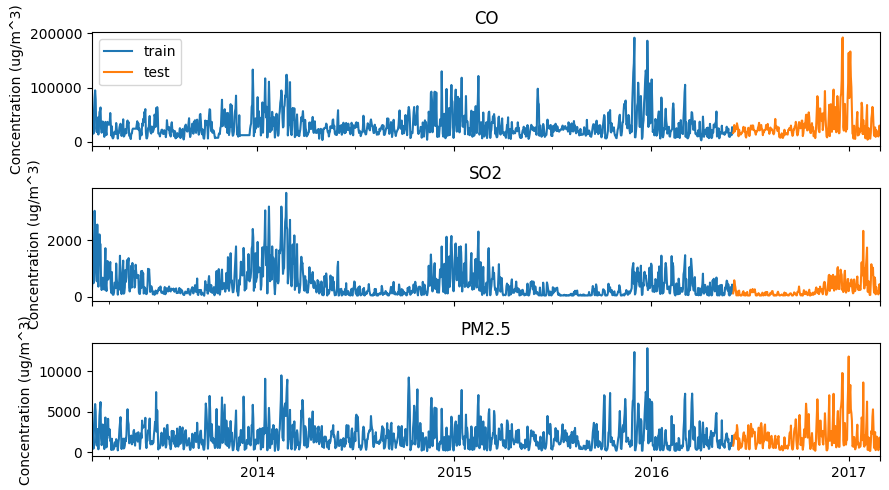

In [4]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['CO'].plot(label='train', ax=axes[0])
data_test['CO'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Concentration (ug/m^3)')
axes[0].set_title('CO')
axes[0].legend()

data_train['SO2'].plot(label='train', ax=axes[1])
data_test['SO2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Concentration (ug/m^3)')
axes[1].set_title('SO2')

data_train['PM2.5'].plot(label='train', ax=axes[2])
data_test['PM2.5'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('Concentration (ug/m^3)')
axes[2].set_title('PM2.5')

fig.tight_layout()
plt.show();

## Train and predict ForecasterAutoregMultiVariate

When initializing the forecaster, the `level` to be predicted and the maximum number of `steps` must be indicated since a different model will be created for each step.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Starting from version <b>skforecast 0.9.0</b>, the <code>ForecasterAutoregMultiVariate</code> now includes the <code>n_jobs</code> parameter, allowing multi-process parallelization. This allows to train regressors for all steps simultaneously.

The benefits of parallelization depend on several factors, including the regressor used, the number of fits to be performed, and the volume of data involved. When the <code>n_jobs</code> parameter is set to <code>'auto'</code>, the level of parallelization is automatically selected based on heuristic rules that aim to choose the best option for each scenario.

For a more detailed look at parallelization, visit <a href="https://skforecast.org/latest/faq/parallelization-skforecast">Parallelization in skforecast</a>.

</div>

In [5]:
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 n_jobs             = 'auto'
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 7 
Target series, level: CO 
Multivariate series (names): ['CO', 'SO2', 'PM2.5'] 
Maximum steps predicted: 7 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2016-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 


When predicting, the value of `steps` must be less than or equal to the value of steps defined when initializing the forecaster. Starts at 1.

+ If `int` only steps within the range of 1 to int are predicted.

+ If `list` of `int`. Only the steps contained in the list are predicted.

+ If `None` as many steps are predicted as were defined at initialization.

In [6]:
# Predict with forecaster MultiVariate
# ==============================================================================
# Predict as many steps as defined in the forecaster initialization
predictions = forecaster.predict()
display(predictions)

CO
2016-06-01  15774.629629
2016-06-02  20083.444808
2016-06-03  20050.403708
2016-06-04  13376.404100
2016-06-05  19181.270877
2016-06-06  16992.101160
2016-06-07  12816.943637

In [7]:
# Predict only a subset of steps
predictions = forecaster.predict(steps=[1, 5])
display(predictions)

CO
2016-06-01  15774.629629
2016-06-05  19181.270877

In [8]:
# Predict with prediction intervals
predictions = forecaster.predict_interval(random_state=9871)
display(predictions)

CO  CO_lower_bound  CO_upper_bound
2016-06-01  15774.629629     9558.136276    23292.089686
2016-06-02  20083.444808    12871.968341    29431.747334
2016-06-03  20050.403708    11856.264198    31166.420347
2016-06-04  13376.404100     4630.535566    22596.844854
2016-06-05  19181.270877    12141.471031    28024.180402
2016-06-06  16992.101160     8467.479012    27957.219037
2016-06-07  12816.943637     4641.922139    21971.627676

## Backtesting MultiVariate

See the [backtesting user guide](https://skforecast.org/0.13.0/user_guides/backtesting.html) to learn more about backtesting.

In [9]:
# Backtesting MultiVariate
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           steps                 = 7,
                                           metric                = 'mean_absolute_error',
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = False,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           n_jobs                = 'auto',
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/39 [00:00<?, ?it/s]

Backtest metrics


levels  mean_absolute_error
0     CO         16577.420604


Backtest predictions


CO
2016-06-01  15774.629629
2016-06-02  20083.444808
2016-06-03  20050.403708
2016-06-04  13376.404100

## Hyperparameter tuning and lags selection MultiVariate

The `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` functions in the `model_selection_multiseries` module allow for lags and hyperparameter optimization. It is performed using the backtesting strategy for validation as in other Forecasters, [see the user guide here](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection).

The following example shows how to use `random_search_forecaster_multiseries` to find the best lags and model hyperparameters.

In [10]:
# Create and forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

In [11]:
# Random search MultiVariate
# ==============================================================================
lags_grid = [7, 14]
param_distributions = {
    'n_estimators': np.arange(start=10, stop=20, step=1, dtype=int),
    'max_depth': np.arange(start=3, stop=6, step=1, dtype=int)
}

results = random_search_forecaster_multiseries(
              forecaster            = forecaster,
              series                = data,
              exog                  = None,
              lags_grid             = lags_grid,
              param_distributions   = param_distributions,
              steps                 = 7,
              metric                = 'mean_absolute_error',
              aggregate_metric      = 'weighted_average',
              initial_train_size    = len(data_train),
              fixed_train_size      = False,
              gap                   = 0,
              allow_incomplete_fold = True,
              refit                 = False,
              n_iter                = 5,
              return_best           = False,
              n_jobs                = 'auto',
              verbose               = False,
              show_progress         = True
          )

results

10 models compared for 1 level(s). Number of iterations: 10.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

levels                                             lags  \
0   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
1   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
2   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
3   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
4   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
5   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
6   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
7   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
8   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
9   [CO]                            [1, 2, 3, 4, 5, 6, 7]   

                                        lags_label  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
5                            [1, 2, 3, 4, 5, 6, 7]   
6                            [1, 2, 3, 4, 5, 6, 7]   
7                            [1, 2, 3, 4, 5, 6, 7]   
8                            [1, 2, 3, 4, 5, 6, 7]   
9                            [1, 2, 3, 4, 5, 6, 7]   

                                 params  mean_absolute_error  n_estimators  \
0  {'n_estimators': 19, 'max_depth': 5}         15345.360485            19   
1  {'n_estimators': 16, 'max_depth': 5}         15380.547039            16   
2  {'n_estimators': 18, 'max_depth': 3}         15556.476445            18   
3  {'n_estimators': 17, 'max_depth': 3}         15581.563438            17   
4  {'n_estimators': 15, 'max_depth': 3}         15644.444887            15   
5  {'n_estimators': 18, 'max_depth': 3}         15707.586121            18   
6  {'n_estimators': 15, 'max_depth': 3}         15715.665149            15   
7  {'n_estimators': 17, 'max_depth': 3}         15718.957694            17   
8  {'n_estimators': 19, 'max_depth': 5}         15895.928301            19   
9  {'n_estimators': 16, 'max_depth': 5}         15909.808527            16   

   max_depth  
0          5  
1          5  
2          3  
3          3  
4          3  
5          3  
6          3  
7          3  
8          5  
9          5

It is also possible to perform a bayesian optimization with `optuna` using the `bayesian_search_forecaster_multiseries` function. For more information about this type of optimization, see the [user guide here](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection#bayesian-search).

In [12]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 level     = 'CO',
                 lags      = 7,
                 steps     = 7
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [7, 14]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    return search_space

results, best_trial = bayesian_search_forecaster_multiseries(
                          forecaster            = forecaster,
                          series                = data,
                          exog                  = None, 
                          search_space          = search_space,
                          steps                 = 7,
                          metric                = 'mean_absolute_error',
                          aggregate_metric      = 'weighted_average',
                          refit                 = False,
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          n_trials              = 5,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )

results.head(4)

  0%|          | 0/5 [00:00<?, ?it/s]

levels                                             lags  \
0   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
1   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
2   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
3   [CO]                            [1, 2, 3, 4, 5, 6, 7]   

                                              params  mean_absolute_error  \
0  {'n_estimators': 16, 'min_samples_leaf': 9, 'm...         15375.511274   
1  {'n_estimators': 14, 'min_samples_leaf': 8, 'm...         16217.723758   
2  {'n_estimators': 13, 'min_samples_leaf': 3, 'm...         16290.935447   
3  {'n_estimators': 12, 'min_samples_leaf': 6, 'm...         16321.561731   

   n_estimators  min_samples_leaf max_features  
0            16                 9         log2  
1            14                 8         log2  
2            13                 3         sqrt  
3            12                 6         log2

`best_trial` contains information of the trial which achived the best results. See more in [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study).

In [13]:
# Optuna best trial in the study
# ==============================================================================
best_trial

FrozenTrial(number=3, state=1, values=[15375.511274206323], datetime_start=datetime.datetime(2024, 7, 29, 16, 45, 29, 687109), datetime_complete=datetime.datetime(2024, 7, 29, 16, 45, 30, 430502), params={'lags': 14, 'n_estimators': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lags': CategoricalDistribution(choices=(7, 14)), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=3, value=None)

## Different lags for each time series

If a `dict` is passed to the `lags` argument, it allows setting different lags for each of the series. The keys of the dictionary must be the names of the series to be used during training.

In [14]:
# Create and fit forecaster MultiVariate Custom lags
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = {'CO': 7, 'SO2': [1, 7], 'PM2.5': 2},
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
display(predictions)

CO
2016-06-01  19689.480156
2016-06-02  20868.146279
2016-06-03  19580.755477
2016-06-04  14345.425771
2016-06-05  18420.497473
2016-06-06  17743.247080
2016-06-07   8241.801326

If a `None` is passed to any of the keys of the `lags` argument, that series will not be used to create the `X` training matrix.

In this example, no lags are created for the `'CO'` series, but since it is the `level` of the forecaster, the `'CO'` column will be used to create the `y` training matrix.

In [15]:
# Create and fit forecaster MultiVariate Custom lags with None
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = {'CO': None, 'SO2': [1, 7], 'PM2.5': 2},
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
display(predictions)

CO
2016-06-01  23729.888429
2016-06-02  25293.547939
2016-06-03  25514.092134
2016-06-04  24602.438413
2016-06-05  22365.681790
2016-06-06  20922.543045
2016-06-07   9068.361606

It is possible to use the `create_train_X_y` method to generate the matrices that the forecaster is using to train the model. This approach enables gaining insight into the specific lags that have been created.

In [16]:
# Extract training matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(series=data_train)

# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
               step    = 1,
               X_train = X,
               y_train = y,
           )

X_1.head(4)

SO2_lag_1  SO2_lag_7  PM2.5_lag_1  PM2.5_lag_2
date                                                      
2013-03-08   3.727899  -0.495413     2.427373     1.806709
2013-03-09   2.102055   0.421426     1.870726     2.427373
2013-03-10   0.825226   2.346788    -0.444267     1.870726
2013-03-11   0.185389   0.052740    -0.702775    -0.444267

In [17]:
# Extract training matrix
# ==============================================================================
y_1.head(4)

date
2013-03-08    2.153622
2013-03-09   -0.221359
2013-03-10   -0.531358
2013-03-11    0.496391
Freq: D, Name: CO_step_1, dtype: float64

## Exogenous variables in MultiVariate

Exogenous variables are predictors that are independent of the model being used for forecasting, and their future values must be known in order to include them in the prediction process.

In the `ForecasterAutoregMultiVariate`, as in the other forecasters, exogenous variables can be easily included as predictors using the `exog` argument.

To learn more about exogenous variables in skforecast visit the [exogenous variables user guide](https://skforecast.org/latest/user_guides/exogenous-variables).

## Scikit-learn transformers in MultiVariate

By default, the `ForecasterAutoregMultiVariate` class uses the scikit-learn `StandardScaler` transformer to scale the data. This transformer is applied to all series. However, it is possible to use different transformers for each series or not to apply any transformation at all:

+ If `transformer_series` is a `transformer` the same transformation will be applied to all series. 

+ If `transformer_series` is a `dict` a different transformation can be set for each series. Series not present in the dict will not have any transformation applied to them (check warning message).

Learn more about [using scikit-learn transformers](https://skforecast.org/latest/user_guides/sklearn-transformers-and-pipeline.html) with skforecast.

In [18]:
# Transformers in MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = {'CO': StandardScaler(), 'SO2': StandardScaler()},
                 transformer_exog   = None,
                 weight_func        = None,
             )

forecaster.fit(series=data_train)
forecaster

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11\Lib\site-packages\skforecast\utils\utils.py:255: IgnoredArgumentWarning: {'PM2.5'} not present in `transformer_series`. No transformation is applied to these series. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


ForecasterAutoregMultiVariate 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: {'CO': StandardScaler(), 'SO2': StandardScaler()} 
Transformer for exog: None 
Weight function included: False 
Window size: 7 
Target series, level: CO 
Multivariate series (names): ['CO', 'SO2', 'PM2.5'] 
Maximum steps predicted: 7 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2016-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'sub

## Weights in MultiVariate

The weights are used to control the influence that each observation has on the training of the model.

Learn more about [weighted time series forecasting](https://skforecast.org/latest/user_guides/weighted-time-series-forecasting) with skforecast.

In [19]:
# Weights in MultiVariate
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights

forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = custom_weights
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=7).head(3)

CO
2016-06-01  15774.629629
2016-06-02  20083.444808
2016-06-03  20050.403708

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>weight_func</code> argument will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`.

In [20]:
# Source code weight function
# ==============================================================================
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights



## Compare multiple metrics

All four functions (`backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`,  `random_search_forecaster_multiseries`, and `bayesian_search_forecaster_multiseries`) allow the calculation of multiple metrics for each forecaster configuration if a list is provided. This list can include custom metrics, and the best model is selected based on the first metric in the list and the first aggregation method (if more than one is provided).

In [21]:
# Grid search MultiVariate with multiple metrics
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7
             )    

def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

lags_grid = [7, 14]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              steps               = 7,
              metric              = [mean_absolute_error, custom_metric, 'mean_squared_error'],
              aggregate_metric    = 'weighted_average',
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = False,
              return_best         = True,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )

results

6 models compared for 1 level(s). Number of iterations: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 16044.246752675152
  Levels: ['CO']



levels                                             lags  \
0   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
1   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
2   [CO]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
3   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
4   [CO]                            [1, 2, 3, 4, 5, 6, 7]   
5   [CO]                            [1, 2, 3, 4, 5, 6, 7]   

                                        lags_label           params  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  {'alpha': 0.01}   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   {'alpha': 0.1}   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]     {'alpha': 1}   
3                            [1, 2, 3, 4, 5, 6, 7]  {'alpha': 0.01}   
4                            [1, 2, 3, 4, 5, 6, 7]   {'alpha': 0.1}   
5                            [1, 2, 3, 4, 5, 6, 7]     {'alpha': 1}   

   mean_absolute_error  custom_metric  mean_squared_error  alpha  
0         16044.246753   22748.759670        6.564519e+08   0.01  
1         16044.246753   22748.759670        6.564519e+08   0.10  
2         16044.246753   22748.759670        6.564519e+08   1.00  
3         16577.420604   23913.019815        6.614748e+08   0.01  
4         16577.420604   23913.019815        6.614748e+08   0.10  
5         16577.420604   23913.019815        6.614748e+08   1.00

## Feature importances

Since `ForecasterAutoregMultiVariate` fits one model per step, it is necessary to specify from which model retrieves its feature importances.

In [22]:
# Feature importances for step 1
# ==============================================================================
forecaster.get_feature_importances(step=1)

feature  importance
0       CO_lag_1         234
1       CO_lag_2         147
29   PM2.5_lag_2         119
30   PM2.5_lag_3         116
14     SO2_lag_1         111
3       CO_lag_4         105
28   PM2.5_lag_1         103
2       CO_lag_3          99
15     SO2_lag_2          88
9      CO_lag_10          87
7       CO_lag_8          78
8       CO_lag_9          76
6       CO_lag_7          74
5       CO_lag_6          73
31   PM2.5_lag_4          70
12     CO_lag_13          69
13     CO_lag_14          68
20     SO2_lag_7          68
4       CO_lag_5          65
36   PM2.5_lag_9          65
33   PM2.5_lag_6          65
37  PM2.5_lag_10          60
17     SO2_lag_4          60
10     CO_lag_11          60
22     SO2_lag_9          58
21     SO2_lag_8          57
34   PM2.5_lag_7          56
11     CO_lag_12          56
16     SO2_lag_3          55
26    SO2_lag_13          53
40  PM2.5_lag_13          51
32   PM2.5_lag_5          50
35   PM2.5_lag_8          50
41  PM2.5_lag_14          50
24    SO2_lag_11          46
38  PM2.5_lag_11          44
27    SO2_lag_14          40
39  PM2.5_lag_12          38
25    SO2_lag_12          35
23    SO2_lag_10          34
19     SO2_lag_6          34
18     SO2_lag_5          33

## Extract training matrix

Two steps are needed. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [23]:
# Extract training matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(series=data_train)

# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
               step          = 1,
               X_train       = X,
               y_train       = y,
               remove_suffix = False
           )

X_1.head(4)

CO_lag_1  CO_lag_2  CO_lag_3  CO_lag_4  CO_lag_5  CO_lag_6  \
date                                                                     
2013-03-15  0.244207 -0.706409  0.620101  0.459426 -0.520511 -0.224933   
2013-03-16  1.038288  0.244207 -0.706409  0.620101  0.459426 -0.520511   
2013-03-17  1.152151  1.038288  0.244207 -0.706409  0.620101  0.459426   
2013-03-18  1.405691  1.152151  1.038288  0.244207 -0.706409  0.620101   

            CO_lag_7  CO_lag_8  CO_lag_9  CO_lag_10  ...  PM2.5_lag_5  \
date                                                 ...                
2013-03-15  2.039562  2.740821  2.170409   1.253719  ...    -0.698503   
2013-03-16 -0.224933  2.039562  2.740821   2.170409  ...     0.517651   
2013-03-17 -0.520511 -0.224933  2.039562   2.740821  ...     0.494469   
2013-03-18  0.459426 -0.520511 -0.224933   2.039562  ...    -0.975496   

            PM2.5_lag_6  PM2.5_lag_7  PM2.5_lag_8  PM2.5_lag_9  PM2.5_lag_10  \
date                                                                           
2013-03-15    -0.446475     1.810484     2.353176     1.748071      0.829120   
2013-03-16    -0.698503    -0.446475     1.810484     2.353176      1.748071   
2013-03-17     0.517651    -0.698503    -0.446475     1.810484      2.353176   
2013-03-18     0.494469     0.517651    -0.698503    -0.446475      1.810484   

            PM2.5_lag_11  PM2.5_lag_12  PM2.5_lag_13  PM2.5_lag_14  
date                                                                
2013-03-15     -0.924377     -0.022069     -0.808468     -1.077140  
2013-03-16      0.829120     -0.924377     -0.022069     -0.808468  
2013-03-17      1.748071      0.829120     -0.924377     -0.022069  
2013-03-18      2.353176      1.748071      0.829120     -0.924377  

[4 rows x 42 columns]

In [24]:
y_1.head(4)

date
2013-03-15    1.038288
2013-03-16    1.152151
2013-03-17    1.405691
2013-03-18   -0.275548
Freq: D, Name: CO_step_1, dtype: float64